In [2]:
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import matplotlib.image as mpimg

In [5]:
import matplotlib.pyplot as plt

In [6]:
import matplotlib.cm as cm

In [7]:
import png

In [52]:
import scipy.ndimage as ndimage

In [36]:
height, width = 100,100

In [37]:
# Step 1. Generate a grid of random unit vectors.
img = np.random.uniform(0,1,height*width)
img = img.reshape(height,width)

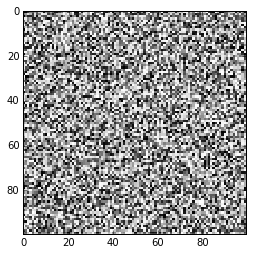

In [38]:
imgplot = plt.imshow(img, cm.Greys_r, interpolation='none')

In [39]:
dx, dt = 1,0.1

In [79]:
edge_threshold = 1

In [81]:
u = np.copy(img)

In [41]:
d = np.zeros((height, width))

In [77]:
def do_step_reflected_boundary_linear_homogeneous(u):
        
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = u[(i[0]+1, i[1])]
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = u[(i[0]-1, i[1])]
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = u[(i[0], i[1]+1)]
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = u[(i[0], i[1]-1)]
        else:
            down = u[(i[0], i[1]+1)]
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= dt
    u += d


In [80]:
def do_step_reflected_boundary_nonlinear_isotropic(u):
        
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = u[(i[0]+1, i[1])]
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = u[(i[0]-1, i[1])]
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = u[(i[0], i[1]+1)]
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = u[(i[0], i[1]-1)]
        else:
            down = u[(i[0], i[1]+1)]
            
        dudx = left + right - 2*u_x
        dudy = up + down - 2*u_x
        
        g = 1.0/(1.0 + (dudx**2 + dudy**2)/(edge_threshold**2))
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= g
        d[i] *= dt
    u += d


In [43]:
def show(img):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none')

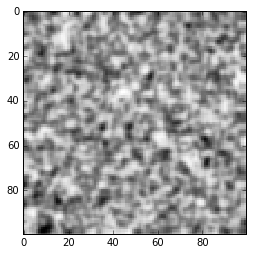

In [84]:
show(u)

In [83]:
for i in xrange(10): do_step_reflected_boundary_nonlinear_isotropic(u)

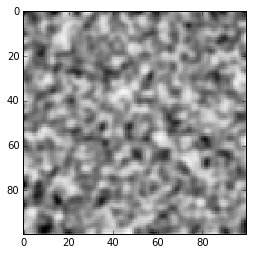

In [71]:
with_blur = ndimage.gaussian_filter(img, sigma=np.sqrt(2)); show(with_blur)

In [76]:
with_blur - u

array([[-0.07718003, -0.07114309, -0.05245428, ..., -0.02530104,
        -0.03442372, -0.05326382],
       [-0.03868018, -0.03891832, -0.03131917, ..., -0.01935323,
        -0.0241681 , -0.03739352],
       [-0.00549539, -0.00964553, -0.00787483, ..., -0.00634485,
        -0.00581431, -0.01221145],
       ..., 
       [ 0.03042647,  0.0185968 ,  0.006392  , ..., -0.00214591,
        -0.02265918, -0.04937572],
       [ 0.0262326 ,  0.02142253,  0.01492389, ...,  0.01624589,
        -0.00643907, -0.03139986],
       [ 0.01781043,  0.02043822,  0.02290662, ...,  0.03049819,
         0.00438306, -0.02150616]])